# Load data and packages

In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import folium
import bokeh
import plotly.express as px
import datetime

In [2]:
import os
import pytz
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import itertools

In [3]:
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config
plt.rcParams['figure.figsize']=(12,3)

In [4]:
set_config(transform_output="pandas")
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
pd.set_option('display.max_columns',50)

In [5]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black', method = 'ywm'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)  
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)    
    # Annotate sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    # seasons
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        # Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        # for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [7]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    # PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [8]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [9]:
all_crime_data = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/seattle_crime/Data/SPD_Crime_Data__2008-Present_20240523-2.csv')

# Inspect data

In [10]:
all_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121395 entries, 0 to 1121394
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Report Number           1121395 non-null  object 
 1   Offense ID              1121395 non-null  int64  
 2   Offense Start DateTime  1119634 non-null  object 
 3   Offense End DateTime    642445 non-null   object 
 4   Report DateTime         1121395 non-null  object 
 5   Group A B               1121395 non-null  object 
 6   Crime Against Category  1121395 non-null  object 
 7   Offense Parent Group    1121395 non-null  object 
 8   Offense                 1121395 non-null  object 
 9   Offense Code            1121395 non-null  object 
 10  Precinct                1121388 non-null  object 
 11  Sector                  1121388 non-null  object 
 12  Beat                    1121388 non-null  object 
 13  MCPP                    1121368 non-null  object 
 14  10

In [11]:
all_crime_data

,Report Number,Offense ID,Offense Start DateTime,Offense End DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Precinct,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
0,2020-044620,12605873663,02/05/2020 10:10:00 AM,NaN,02/05/2020 11:24:31 AM,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,W,Q,Q1,MAGNOLIA,32XX BLOCK OF 23RD AVE W,-122.385974,47.649387
1,2020-044452,12605598696,02/03/2020 08:00:00 AM,02/04/2020 08:00:00 AM,02/05/2020 10:06:28 AM,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,J,J3,ROOSEVELT/RAVENNA,63XX BLOCK OF 5TH AVE NE,-122.323399,47.675118
2,2020-044465,12605567653,02/02/2020 08:30:00 PM,02/02/2020 09:30:00 PM,02/05/2020 09:39:33 AM,A,PROPERTY,ROBBERY,Robbery,120,N,U,U3,ROOSEVELT/RAVENNA,26TH AVE NE / NE BLAKELEY ST,-122.299552,47.666384
3,2020-044225,12605174036,02/05/2020 01:17:00 AM,02/05/2020 02:21:00 AM,02/05/2020 03:30:55 AM,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,Q,Q1,MAGNOLIA,22XX BLOCK OF W RAYE ST,-122.384865,47.642927
4,2020-044076,12605081469,02/05/2020 12:51:21 AM,NaN,02/05/2020 12:51:31 AM,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,B,B2,BALLARD SOUTH,NW 46TH ST / 8TH AVE NW,-122.366195,47.662193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121390,2013-247888,7687554356,07/13/2013 01:00:00 AM,NaN,07/13/2013 06:37:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,SW,F,F1,PIGEON POINT,41XX BLOCK OF 20TH AVE SW,-122.359028,47.565702
1121391,2013-227022,7682354808,06/26/2013 11:00:00 AM,06/29/2013 06:30:00 AM,06/29/2013 09:43:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,W,Q,Q3,QUEEN ANNE,1ST AVE N / VALLEY ST,-122.355386,47.626251
1121392,2012-045494,7672915592,02/14/2012 03:04:00 PM,NaN,02/14/2012 03:04:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,N,U,U1,ROOSEVELT/RAVENNA,73XX BLOCK OF ROOSEVELT WAY NE,-122.317464,47.681894
1121393,2010-328592,7692227482,09/19/2010 04:59:00 PM,NaN,09/19/2010 04:59:00 PM,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,W,M,M3,DOWNTOWN COMMERCIAL,5XX BLOCK OF PIKE ST,-122.335018,47.610909


In [12]:
all_crime_data['Report DateTime'] = pd.to_datetime(all_crime_data['Report DateTime'], format = '%m/%d/%Y %H:%M:%S %p')

In [13]:
crime_data = all_crime_data.set_index(['Report DateTime'])
crime_data

,Report Number,Offense ID,Offense Start DateTime,Offense End DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Precinct,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
Report DateTime,,,,,,,,,,,,,,,,
2020-02-05 11:24:31,2020-044620,12605873663,02/05/2020 10:10:00 AM,NaN,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,W,Q,Q1,MAGNOLIA,32XX BLOCK OF 23RD AVE W,-122.385974,47.649387
2020-02-05 10:06:28,2020-044452,12605598696,02/03/2020 08:00:00 AM,02/04/2020 08:00:00 AM,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,J,J3,ROOSEVELT/RAVENNA,63XX BLOCK OF 5TH AVE NE,-122.323399,47.675118
2020-02-05 09:39:33,2020-044465,12605567653,02/02/2020 08:30:00 PM,02/02/2020 09:30:00 PM,A,PROPERTY,ROBBERY,Robbery,120,N,U,U3,ROOSEVELT/RAVENNA,26TH AVE NE / NE BLAKELEY ST,-122.299552,47.666384
2020-02-05 03:30:55,2020-044225,12605174036,02/05/2020 01:17:00 AM,02/05/2020 02:21:00 AM,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,Q,Q1,MAGNOLIA,22XX BLOCK OF W RAYE ST,-122.384865,47.642927
2020-02-05 12:51:31,2020-044076,12605081469,02/05/2020 12:51:21 AM,NaN,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,B,B2,BALLARD SOUTH,NW 46TH ST / 8TH AVE NW,-122.366195,47.662193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-13 06:37:00,2013-247888,7687554356,07/13/2013 01:00:00 AM,NaN,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,SW,F,F1,PIGEON POINT,41XX BLOCK OF 20TH AVE SW,-122.359028,47.565702
2013-06-29 09:43:00,2013-227022,7682354808,06/26/2013 11:00:00 AM,06/29/2013 06:30:00 AM,A,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,240,W,Q,Q3,QUEEN ANNE,1ST AVE N / VALLEY ST,-122.355386,47.626251
2012-02-14 03:04:00,2012-045494,7672915592,02/14/2012 03:04:00 PM,NaN,A,PROPERTY,LARCENY-THEFT,Shoplifting,23C,N,U,U1,ROOSEVELT/RAVENNA,73XX BLOCK OF ROOSEVELT WAY NE,-122.317464,47.681894


In [14]:
crime_data_simple = crime_data.drop(columns=['Offense ID', 'Offense Start DateTime', 'Offense End DateTime', 'Group A B', 'Offense Code', 'Sector', 'Beat', '100 Block Address'])

In [15]:
crime_data_simple

,Report Number,Crime Against Category,Offense Parent Group,Offense,Precinct,MCPP,Longitude,Latitude
Report DateTime,,,,,,,,
2020-02-05 11:24:31,2020-044620,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,W,MAGNOLIA,-122.385974,47.649387
2020-02-05 10:06:28,2020-044452,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,N,ROOSEVELT/RAVENNA,-122.323399,47.675118
2020-02-05 09:39:33,2020-044465,PROPERTY,ROBBERY,Robbery,N,ROOSEVELT/RAVENNA,-122.299552,47.666384
2020-02-05 03:30:55,2020-044225,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,W,MAGNOLIA,-122.384865,47.642927
2020-02-05 12:51:31,2020-044076,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,N,BALLARD SOUTH,-122.366195,47.662193
...,...,...,...,...,...,...,...,...
2013-07-13 06:37:00,2013-247888,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,SW,PIGEON POINT,-122.359028,47.565702
2013-06-29 09:43:00,2013-227022,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,W,QUEEN ANNE,-122.355386,47.626251
2012-02-14 03:04:00,2012-045494,PROPERTY,LARCENY-THEFT,Shoplifting,N,ROOSEVELT/RAVENNA,-122.317464,47.681894


In [16]:
crime_data_simple.to_csv('/Users/marcolaureano2/Documents/GitHub/seattle_crime/Data/crime_data_simple.csv')

In [17]:
crime_data_simple

,Report Number,Crime Against Category,Offense Parent Group,Offense,Precinct,MCPP,Longitude,Latitude
Report DateTime,,,,,,,,
2020-02-05 11:24:31,2020-044620,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,W,MAGNOLIA,-122.385974,47.649387
2020-02-05 10:06:28,2020-044452,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,N,ROOSEVELT/RAVENNA,-122.323399,47.675118
2020-02-05 09:39:33,2020-044465,PROPERTY,ROBBERY,Robbery,N,ROOSEVELT/RAVENNA,-122.299552,47.666384
2020-02-05 03:30:55,2020-044225,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,W,MAGNOLIA,-122.384865,47.642927
2020-02-05 12:51:31,2020-044076,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,N,BALLARD SOUTH,-122.366195,47.662193
...,...,...,...,...,...,...,...,...
2013-07-13 06:37:00,2013-247888,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,SW,PIGEON POINT,-122.359028,47.565702
2013-06-29 09:43:00,2013-227022,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,W,QUEEN ANNE,-122.355386,47.626251
2012-02-14 03:04:00,2012-045494,PROPERTY,LARCENY-THEFT,Shoplifting,N,ROOSEVELT/RAVENNA,-122.317464,47.681894


# inspect columns

In [18]:
all_crime_data['Crime Against Category'].unique()

array(['SOCIETY', 'PROPERTY', 'PERSON', 'NOT_A_CRIME'], dtype=object)

In [19]:
all_crime_data['Offense Parent Group'].unique()

array(['DRUG/NARCOTIC OFFENSES', 'LARCENY-THEFT', 'ROBBERY',
       'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY',
       'DRIVING UNDER THE INFLUENCE', 'FRAUD OFFENSES',
       'KIDNAPPING/ABDUCTION', 'COUNTERFEITING/FORGERY',
       'PORNOGRAPHY/OBSCENE MATERIAL', 'EXTORTION/BLACKMAIL',
       'MOTOR VEHICLE THEFT', 'SEX OFFENSES', 'STOLEN PROPERTY OFFENSES',
       'EMBEZZLEMENT', 'WEAPON LAW VIOLATIONS', 'ARSON',
       'HUMAN TRAFFICKING', 'LIQUOR LAW VIOLATIONS', 'BAD CHECKS',
       'PROSTITUTION OFFENSES', 'FAMILY OFFENSES, NONVIOLENT',
       'CURFEW/LOITERING/VAGRANCY VIOLATIONS', 'ANIMAL CRUELTY',
       'HOMICIDE OFFENSES', 'PEEPING TOM', 'DRUNKENNESS',
       'SEX OFFENSES, CONSENSUAL', 'BRIBERY', 'GAMBLING OFFENSES',
       'TRESPASS OF REAL PROPERTY', 'ASSAULT OFFENSES',
       'BURGLARY/BREAKING&ENTERING'], dtype=object)

In [20]:
all_crime_data['Offense'].unique()

array(['Drug/Narcotic Violations',
       'Theft of Motor Vehicle Parts or Accessories', 'Robbery',
       'Destruction/Damage/Vandalism of Property',
       'Driving Under the Influence', 'Shoplifting',
       'Theft From Motor Vehicle', 'Wire Fraud', 'Theft From Building',
       'Kidnapping/Abduction', 'Counterfeiting/Forgery',
       'All Other Larceny', 'Pornography/Obscene Material',
       'Extortion/Blackmail', 'Motor Vehicle Theft', 'Sodomy',
       'Stolen Property Offenses',
       'False Pretenses/Swindle/Confidence Game',
       'Credit Card/Automated Teller Machine Fraud', 'Embezzlement',
       'Identity Theft', 'Impersonation', 'Weapon Law Violations',
       'Fondling', 'Hacking/Computer Invasion',
       'Drug Equipment Violations', 'Arson',
       'Human Trafficking, Commercial Sex Acts', 'Liquor Law Violations',
       'Bad Checks', 'Pocket-picking', 'Rape',
       'Sexual Assault With An Object', 'Purchasing Prostitution',
       'Purse-snatching', 'Family Offenses

In [21]:
crime_groups = all_crime_data.groupby(['Crime Against Category', 'Offense Parent Group']).count()

In [22]:
crime_groups

Report Number  \
Crime Against Category Offense Parent Group                                      
NOT_A_CRIME            HOMICIDE OFFENSES                                    34   
PERSON                 ASSAULT OFFENSES                                 162169   
                       HOMICIDE OFFENSES                                   527   
                       HUMAN TRAFFICKING                                    72   
                       KIDNAPPING/ABDUCTION                               1561   
                       SEX OFFENSES                                       7335   
                       SEX OFFENSES, CONSENSUAL                            208   
PROPERTY               ARSON                                              2009   
                       BAD CHECKS                                         6710   
                       BRIBERY                                              18   
                       BURGLARY/BREAKING&ENTERING                       127113   
                       COUNTERFEITING/FORGERY                             5603   
                       DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY         104864   
                       EMBEZZLEMENT                                       2065   
                       EXTORTION/BLACKMAIL                                1059   
                       FRAUD OFFENSES                                    63002   
                       LARCENY-THEFT                                    414360   
                       MOTOR VEHICLE THEFT                               76934   
                       ROBBERY                                           26143   
                       STOLEN PROPERTY OFFENSES                           7331   
SOCIETY                ANIMAL CRUELTY                                      188   
                       CURFEW/LOITERING/VAGRANCY VIOLATIONS                905   
                       DRIVING UNDER THE INFLUENCE                       19784   
                       DRUG/NARCOTIC OFFENSES                            28579   
                       DRUNKENNESS                                          20   
                       FAMILY OFFENSES, NONVIOLENT                       10412   
                       GAMBLING OFFENSES                                    28   
                       LIQUOR LAW VIOLATIONS                              2341   
                       PEEPING TOM                                         202   
                       PORNOGRAPHY/OBSCENE MATERIAL                        469   
                       PROSTITUTION OFFENSES                              4106   
                       TRESPASS OF REAL PROPERTY                         34265   
                       WEAPON LAW VIOLATIONS                             10979   

                                                                 Offense ID  \
Crime Against Category Offense Parent Group                                   
NOT_A_CRIME            HOMICIDE OFFENSES                                 34   
PERSON                 ASSAULT OFFENSES                              162169   
                       HOMICIDE OFFENSES                                527   
                       HUMAN TRAFFICKING                                 72   
                       KIDNAPPING/ABDUCTION                            1561   
                       SEX OFFENSES                                    7335   
                       SEX OFFENSES, CONSENSUAL                         208   
PROPERTY               ARSON                                           2009   
                       BAD CHECKS                                      6710   
                       BRIBERY                                           18   
                       BURGLARY/BREAKING&ENTERING                    127113   
                       COUNTERFEITING/FORGERY                          5603   
                       DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY      104864   
         

In [23]:
all_crime_data['Offense Code'].unique()

array(['35A', '23G', '120', '290', '90D', '23C', '23F', '26E', '23D',
       '100', '250', '23H', '370', '210', '240', '11B', '280', '26A',
       '26B', '270', '26F', '26C', '520', '11D', '26G', '35B', '200',
       '64A', '90G', '90A', '23A', '11A', '11C', '40C', '23B', '90F',
       '23E', '90B', '720', '09A', '40A', '26D', '90H', '40B', '90E',
       '09C', '36A', '36B', '510', '39B', '39A', '09B', '39C', '90J',
       '13B', '13A', '13C', '220', '64B'], dtype=object)

In [24]:
all_crime_data['Offense Code'].value_counts()

23F    176879
220    127113
290    104864
23H     94397
13B     84985
240     76934
23C     68138
23G     39628
13A     38849
13C     38335
90J     34265
23D     31078
120     26143
35A     24638
26B     20288
90D     19784
26F     13400
26C     12874
26A     12145
520     10979
90F     10412
280      7331
90A      6710
250      5603
35B      3941
26E      3778
40A      3606
11D      3396
23A      3115
11A      2632
90G      2341
270      2065
200      2009
100      1561
210      1059
11B       911
90B       905
23B       734
09A       505
370       469
26G       440
11C       396
23E       391
40B       282
40C       218
90H       202
720       188
36B       163
26D        77
64A        69
36A        45
09C        34
39A        22
09B        22
90E        20
510        18
39B         5
64B         3
39C         1
Name: Offense Code, dtype: int64

In [25]:
crime_codes = crime_data.groupby(['Crime Against Category', 'Offense Code']).count()

In [26]:
crime_codes

Report Number  Offense ID  \
Crime Against Category Offense Code                              
NOT_A_CRIME            09C                      34          34   
PERSON                 09A                     505         505   
                       09B                      22          22   
                       100                    1561        1561   
                       11A                    2632        2632   
                       11B                     911         911   
                       11C                     396         396   
                       11D                    3396        3396   
                       13A                   38849       38849   
                       13B                   84985       84985   
                       13C                   38335       38335   
                       36A                      45          45   
                       36B                     163         163   
                       64A                      69          69   
                       64B                       3           3   
PROPERTY               120                   26143       26143   
                       200                    2009        2009   
                       210                    1059        1059   
                       220                  127113      127113   
                       23A                    3115        3115   
                       23B                     734         734   
                       23C                   68138       68138   
                       23D                   31078       31078   
                       23E                     391         391   
                       23F                  176879      176879   
                       23G                   39628       39628   
                       23H                   94397       94397   
                       240                   76934       76934   
                       250                    5603        5603   
                       26A                   12145       12145   
                       26B                   20288       20288   
                       26C                   12874       12874   
                       26D                      77          77   
                       26E                    3778        3778   
                       26F                   13400       13400   
                       26G                     440         440   
                       270                    2065        2065   
                       280                    7331        7331   
                       290                  104864      104864   
                       510                      18          18   
                       90A                    6710        6710   
SOCIETY                35A                   24638       24638   
                       35B                    3941        3941   
                       370                     469         469   
                       39A                      22          22   
                       39B                       5           5   
                       39C                       1           1   
                       40A                    3606        3606   
                       40B                     282         282   
                       40C                     218         218   
                       520                   10979       10979   
                       720                     188         188   
                       90B                     905         905   
                       90D                   19784       19784   
                       90E                      20          20   
                       90F                   10412       10412   
                       90G                    2341        2341   
                       90H                     202         202   
                       90J                   34265       34265   

          

## Is Crime increasing or decreasing

In [27]:
crime_data_simple

,Report Number,Crime Against Category,Offense Parent Group,Offense,Precinct,MCPP,Longitude,Latitude
Report DateTime,,,,,,,,
2020-02-05 11:24:31,2020-044620,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,W,MAGNOLIA,-122.385974,47.649387
2020-02-05 10:06:28,2020-044452,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,N,ROOSEVELT/RAVENNA,-122.323399,47.675118
2020-02-05 09:39:33,2020-044465,PROPERTY,ROBBERY,Robbery,N,ROOSEVELT/RAVENNA,-122.299552,47.666384
2020-02-05 03:30:55,2020-044225,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,W,MAGNOLIA,-122.384865,47.642927
2020-02-05 12:51:31,2020-044076,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,N,BALLARD SOUTH,-122.366195,47.662193
...,...,...,...,...,...,...,...,...
2013-07-13 06:37:00,2013-247888,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,SW,PIGEON POINT,-122.359028,47.565702
2013-06-29 09:43:00,2013-227022,PROPERTY,MOTOR VEHICLE THEFT,Motor Vehicle Theft,W,QUEEN ANNE,-122.355386,47.626251
2012-02-14 03:04:00,2012-045494,PROPERTY,LARCENY-THEFT,Shoplifting,N,ROOSEVELT/RAVENNA,-122.317464,47.681894


In [28]:
crime_data_simple.columns

Index(['Report Number', 'Crime Against Category', 'Offense Parent Group',
       'Offense', 'Precinct', 'MCPP', 'Longitude', 'Latitude'],
      dtype='object')

In [34]:
offense_groups = crime_data_simple[['Offense Parent Group']]
crime_resample = offense_groups.resample('A').count().copy()

In [48]:
offense_groups

,Offense Parent Group
Report DateTime,
2020-02-05 11:24:31,DRUG/NARCOTIC OFFENSES
2020-02-05 10:06:28,LARCENY-THEFT
2020-02-05 09:39:33,ROBBERY
2020-02-05 03:30:55,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY
2020-02-05 12:51:31,DRIVING UNDER THE INFLUENCE
...,...
2013-07-13 06:37:00,MOTOR VEHICLE THEFT
2013-06-29 09:43:00,MOTOR VEHICLE THEFT
2012-02-14 03:04:00,LARCENY-THEFT


In [35]:
crime_resample

,Offense Parent Group
Report DateTime,
2008-12-31,64420
2009-12-31,65392
2010-12-31,63309
2011-12-31,59254
2012-12-31,58852
2013-12-31,63615
2014-12-31,69568
2015-12-31,67870
2016-12-31,70380


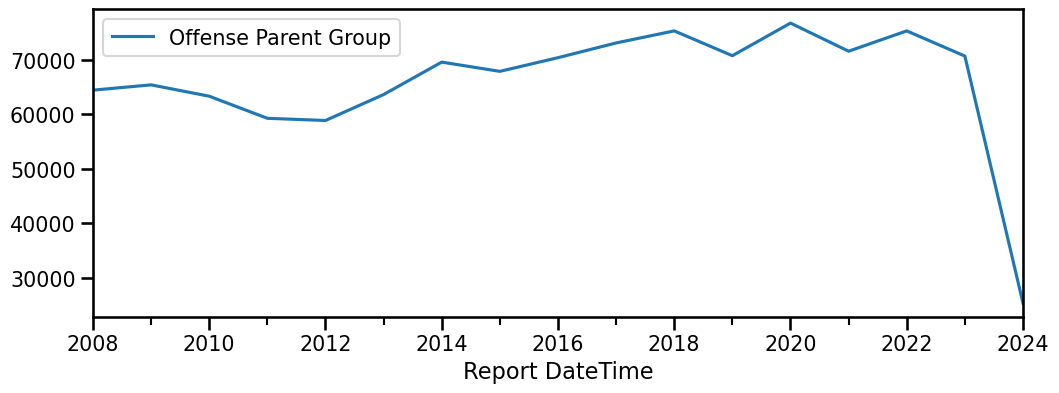

In [40]:
crime_resample.plot();

The total number of reported crimes seems to be increasing

In [30]:
crime_counts = crime_data_simple.groupby('Offense Parent Group').value_counts().sort_index()
crime_counts

Offense Parent Group   Report Number  Crime Against Category  Offense                Precinct  MCPP               Longitude    Latitude 
ANIMAL CRUELTY         2019-185664    SOCIETY                 Animal Cruelty         N         WALLINGFORD        -122.333731  47.661757    1
                       2019-191013    SOCIETY                 Animal Cruelty         SW        HIGH POINT         -122.363164  47.535518    1
                       2019-203555    SOCIETY                 Animal Cruelty         E         MILLER PARK         0.000000    0.000000     1
                       2019-235853    SOCIETY                 Animal Cruelty         S         NORTH BEACON HILL  -122.306470  47.566432    1
                       2019-241610    SOCIETY                 Animal Cruelty         S         MID BEACON HILL    -122.309908  47.549352    1
                                                                                                                                           ..
WEAPON LAW 

In [43]:
crime_plot = all_crime_data[['Offense Parent Group']]
crime_plot

,Offense Parent Group
0,DRUG/NARCOTIC OFFENSES
1,LARCENY-THEFT
2,ROBBERY
3,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY
4,DRIVING UNDER THE INFLUENCE
...,...
1121390,MOTOR VEHICLE THEFT
1121391,MOTOR VEHICLE THEFT
1121392,LARCENY-THEFT
1121393,LARCENY-THEFT


In [44]:
crime_plot.value_counts()

Offense Parent Group                    
LARCENY-THEFT                               414360
ASSAULT OFFENSES                            162169
BURGLARY/BREAKING&ENTERING                  127113
DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY    104864
MOTOR VEHICLE THEFT                          76934
FRAUD OFFENSES                               63002
TRESPASS OF REAL PROPERTY                    34265
DRUG/NARCOTIC OFFENSES                       28579
ROBBERY                                      26143
DRIVING UNDER THE INFLUENCE                  19784
WEAPON LAW VIOLATIONS                        10979
FAMILY OFFENSES, NONVIOLENT                  10412
SEX OFFENSES                                  7335
STOLEN PROPERTY OFFENSES                      7331
BAD CHECKS                                    6710
COUNTERFEITING/FORGERY                        5603
PROSTITUTION OFFENSES                         4106
LIQUOR LAW VIOLATIONS                         2341
EMBEZZLEMENT                             